In [37]:
libraries = c("dplyr", "tidyverse")
for(x in libraries) { library(x,character.only=TRUE,warn.conflicts=FALSE,quietly=TRUE) }

In [38]:
## MPX incidence data
read.csv("../data/incidence/owid-monkeypox-data.csv") -> df_inci
df_inci %<>% filter(!(location %in% c("World"))) %>%  
dplyr::select(location, iso_code, date, new_cases, total_cases)

df_inci %>% arrange(date) %>% group_by(iso_code) %>% filter(rank(date)==1) %>% 
dplyr::select(iso_code, date) %>% rename(date_import = date) -> temp
merge(df_inci, temp, by=c("iso_code"), all.x=TRUE) -> df_inci

write.csv(df_inci, "../data/incidence/df_inci.csv")

In [42]:
## MSM population
read.csv("../data/MSM_pop/df_MSM_UNAIDS.csv") -> df_MSM1
read.csv("../data/MSM_pop/df_full_list_MSMsize_Fumi.csv") -> df_MSM2

## revising the pop2022 column from df_MSM2
read.csv("../data/MSM_pop/df_pop_raw.csv") %>% dplyr::select(cca2, pop2022) %>% rename(iso_2=cca2) -> df_pop1
read.csv("../data/MSM_pop/df_region.csv") %>% dplyr::select(alpha.2,alpha.3, name) %>%
rename(iso_2=alpha.2, iso_code=alpha.3, location=name) -> df_pop2
merge(df_pop1, df_pop2, by=c("iso_2")) -> df_pop
merge(df_MSM2 %>% dplyr::select(-pop2022), 
      df_pop %>% dplyr::select(iso_code, pop2022), by=c("iso_code"), all.x=TRUE) -> df_MSM2

## giving a priority to UNAIDS dashboard
merge(df_MSM1, df_MSM2, by=c("location"),all=TRUE) %>% 
dplyr::select(location, iso_code, estimate, MSM_size, region, sub_region, pop2022) %>%
mutate(prop=estimate/pop2022) %>%
mutate(imputed=case_when(!is.na(estimate) ~ estimate, is.na(estimate) & !is.na(MSM_size) ~ MSM_size), 
       prop=imputed/pop2022) -> temp

## imputation of missing values
temp %>% group_by(sub_region) %>% drop_na(imputed) %>% summarise(prop_avg = mean(prop)) -> prop_avg
merge(temp, prop_avg, by=c("sub_region"), all.x=TRUE) %>% drop_na(pop2022) %>%
mutate(prop=case_when(!is.na(prop)~prop, is.na(prop)~prop_avg),
       imputed=case_when(!is.na(imputed)~imputed, is.na(imputed)~prop*pop2022)) -> df_MSM_imputed


## modifying Samoa with the UNAIDS report
df_MSM_imputed %>% mutate(imputed=case_when(location==c("Samoa")~MSM_size, TRUE~imputed),
                          prop=case_when(location==c("Samoa")~MSM_size/pop2022, TRUE~prop)) -> df_MSM_imputed

df_MSM_imputed %>% head()
write.csv(df_MSM_imputed, "../data/MSM_pop/df_MSM_imputed.csv")

,sub_region,location,iso_code,estimate,MSM_size,region,pop2022,prop,imputed,prop_avg
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Australia and New Zealand,New Zealand,NZL,37.5,84.52019,Oceania,5185.288,0.007231999,37.5000,0.008648965
2,Australia and New Zealand,Australia,AUS,263.5,426.69183,Oceania,26177.413,0.010065930,263.5000,0.008648965
3,Central Asia,Turkmenistan,TKM,NA,135.68925,Asia,6430.770,0.021100000,135.6892,0.009858269
4,Central Asia,Tajikistan,TJK,13.4,210.00381,Asia,9952.787,0.001346357,13.4000,0.009858269
5,Central Asia,Uzbekistan,UZB,NA,730.64346,Asia,34627.652,0.021100000,730.6435,0.009858269
6,Central Asia,Kazakhstan,KAZ,62.0,409.29776,Asia,19397.998,0.003196206,62.0000,0.009858269


228 codes from your data successfully matched countries in the map
6 codes from your data failed to match with a country code in the map
15 codes from the map weren't represented in your data


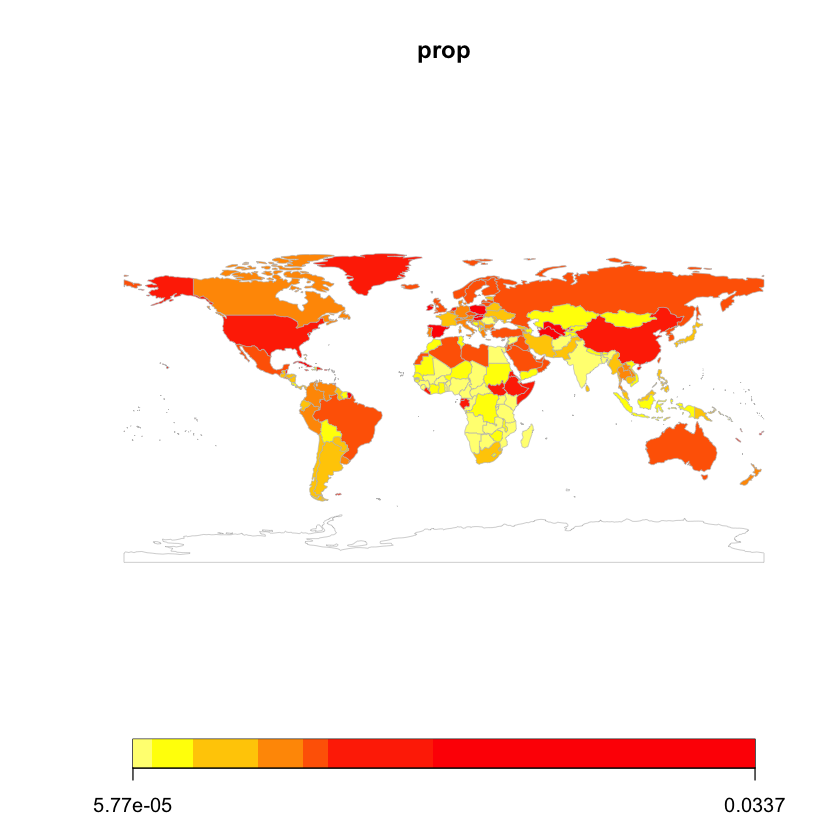

In [44]:
df_MSM_imputed %>% dplyr::select(iso_code, prop) -> fig_MSM
Map = joinCountryData2Map(fig_MSM, joinCode = "ISO3", nameJoinColumn ="iso_code", mapResolution = "coarse") 
mapCountryData(Map, nameColumnToPlot="prop")

In [46]:
merge(df_inci, df_MSM_imputed %>% dplyr::select(iso_code, imputed, pop2022, prop_avg), 
      by=c("iso_code"), all.x=TRUE) -> df_all_inci
write.csv(df_all_inci, "../data/MSM_pop/df_all_inci.csv")
df_all_inci %>% head()

,iso_code,location,date,new_cases,total_cases,date_import,imputed,pop2022,prop_avg
,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>
1,ABW,Aruba,2022/08/26,0,1,2022/08/21,3.587197,106.445,0.0158484
2,ABW,Aruba,2022/09/04,0,2,2022/08/21,3.587197,106.445,0.0158484
3,ABW,Aruba,2022/08/27,0,1,2022/08/21,3.587197,106.445,0.0158484
4,ABW,Aruba,2022/09/08,0,2,2022/08/21,3.587197,106.445,0.0158484
5,ABW,Aruba,2022/09/05,0,2,2022/08/21,3.587197,106.445,0.0158484
6,ABW,Aruba,2022/08/23,0,0,2022/08/21,3.587197,106.445,0.0158484
